In [1]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS2D import DistributionFits2D
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend


Welcome to JupyROOT 6.26/06


In [2]:
pas="1"
config="3"

# Quasi-Elastic Cuts 

In [3]:
W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
nBins=CONFIG.Function_JSON("nBins",f"../config/cuts{config}.cfg")

#kin3
#dymin=-.7895
#dymax=.7895
#W2max=1.2
#dybgmin=-1.2
#dybgmax=1.2
#dxmin=-.5
#dxmax=.5
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'nBins: {nBins}')
#nBins=150
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: -0.5
W2max: 1.7
dxmin: -0.4
dxmax: 0.4
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
nBins: 100
Coin Min: 88 Coin Max: 100


In [4]:
def asymmetrySIMFIT(config):
    r.gErrorIgnoreLevel = r.kError  # Suppress Info and Warning messages
    gStyle.SetOptStat(0)
    gStyle.SetOptFit(1)

    #_____bring in config values______#
    coinVector = CONFIG.Function_JSON("GEN" + config, "../config/coin.cfg")
    he3spot = CONFIG.Function_JSON("GEN" + config + "He3", "../config/spotsize.cfg")
    he3spotsim = CONFIG.Function_JSON("GEN" + config + "He3sim", "../config/spotsize.cfg")
    
    # Set coincidence cut and spot cut values
    coinSigma = 2.5
    coin_low = coinVector[0] - coinSigma * coinVector[1]
    coin_high = coinVector[0] + coinSigma * coinVector[1]

    # Spot imports for dx, dy high and low
    hiydata = he3spot[1]
    lowydata = he3spot[0]
    
    hixdatan = he3spotsim[7]
    lowxdatan = he3spotsim[6]
    hixdatap = he3spotsim[5]
    lowxdatap = he3spotsim[4]
    
    hix_n_3 = he3spotsim[7]
    lowx_n_3 = he3spotsim[6]
    hix_p_3 = he3spotsim[5]
    lowx_p_3 = he3spotsim[4]
    hiy_p3 = he3spotsim[1]
    lowy_p3 = he3spotsim[0]
    hiy_n3 = he3spotsim[3]
    lowy_n3 = he3spotsim[2]
    
    rxn3 = (hix_n_3 - lowx_n_3) / 2.0
    rxp3 = (hix_p_3 - lowx_p_3) / 2.0
    ryp3 = (hiy_p3 - lowy_p3) / 2.0
    ryn3 = (hiy_n3 - lowy_n3) / 2.0

    x0_n3 = (hix_n_3 + lowx_n_3) / 2.0
    x0_p3 = (hix_p_3 + lowx_p_3) / 2.0
    y0_3 = (hiy_p3 + lowy_p3) / 2.0
    
    #-------------------------------------
    rootfilenp = f"../outfiles/Pass1/QE_data_GEN{config}_sbs100p_nucleon_np_model2.root"
    rootfilep = f"../outfiles/Pass1/QE_sim_GEN{config}_sbs100p_nucleon_np_model2.root"
    rootfileIn=rootfilep
    rootfileIn=f"../outfiles/Pass1/QE_Insim_GEN{config}_sbs100p_nucleon_np_model2.root"
    C = TChain("Tout")
    B = TChain("Tout")
    D = TChain("Tout")
    C.Add(rootfilenp)
    B.Add(rootfilep)
    D.Add(rootfileIn)
    dx_p, dy_p, W2_p, coin_p, fnucl = array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    dx_np, dy_np, W2_np, coin_np, weight,weight_In = array.array('d', [0]),array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    helicity_p, IHWP_p, runnum_p = array.array('i', [0]), array.array('i', [0]), array.array('i', [0])
    helicity_np, IHWP_np, runnum_np = array.array('i', [0]), array.array('i', [0]), array.array('i', [0])
    dx_In,dy_In,W2_In=array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    # Disable all branches initially
    C.SetBranchStatus("*", 0)
    B.SetBranchStatus("*", 0)
    D.SetBranchStatus("*", 0)

    # Enable specific branches
    branches = ["dx", "dy", "W2", "helicity", "IHWP", "runnum", "coinCut", "coin_time"]
    b2 = ["dx", "dy", "W2"]
    for branch in branches:
        C.SetBranchStatus(branch, 1)
    for branch in b2:
        B.SetBranchStatus(branch, 1)
        D.SetBranchStatus(branch, 1)
    B.SetBranchStatus("weight", 1)
    D.SetBranchStatus("weight", 1)
    B.SetBranchStatus("fnucl", 1)

    # Set branch addresses
    C.SetBranchAddress("dx", dx_np)
    B.SetBranchAddress("dx", dx_p)
    D.SetBranchAddress("dx", dx_In)
    C.SetBranchAddress("dy", dy_np)
    B.SetBranchAddress("dy", dy_p)
    D.SetBranchAddress("dy", dy_In)
    C.SetBranchAddress("W2", W2_np)
    B.SetBranchAddress("W2", W2_p)
    D.SetBranchAddress("W2", W2_In)
    C.SetBranchAddress("helicity", helicity_np)
    C.SetBranchAddress("IHWP", IHWP_np)
    C.SetBranchAddress("coin_time", coin_np)
    C.SetBranchAddress("runnum", runnum_np)
    B.SetBranchAddress("weight", weight)
    D.SetBranchAddress("weight", weight_In)
    B.SetBranchAddress("fnucl", fnucl)
    
    # Assuming the variables are already defined or loaded from the ROOT file
    nbins = 100   
    xmin, xmax = -4,2.5
    ymin, ymax = -1.5,1.5  # Add appropriate ymin and ymax

    if config == "2":
        xmin = -5.5
        xmax = 2.8
    hdx_data_sim=r.TH1F("hdx_data_sim","Inelastic Simulation 1d",nbins,xmin,xmax)
    hdx_bg_sim=r.TH1F("hdx_bg_sim","Inelastic Simulation 1d",nbins,xmin,xmax)
    hinelastics=r.TH2F("hInelastics","Inelastic Simulation",nbins,xmin,xmax,nbins,ymin,ymax)
    hdx_total_data = r.TH2F("hdx_total_data", "#Deltax;#Deltax;Entries", nbins, xmin, xmax, nbins, ymin, ymax)
    hdx_total_sim = r.TH2F("hdx_total_sim", "#Deltax;#Deltax;Entries", nbins, xmin, xmax, nbins, ymin, ymax)
    hdx_sim_p = r.TH2F("hdx_sim_p", "#Deltax for helicity +1;#Deltax;Entries", nbins, xmin, xmax, nbins, ymin, ymax)
    hdx_sim_n = r.TH2F("hdx_sim_n", "#Deltax for helicity -1;#Deltax;Entries", nbins, xmin, xmax, nbins, ymin, ymax)
    hdx_data_plus = r.TH1F("hdx_data_plus", "", nbins, xmin, xmax)
    hdx_data_minus = r.TH1F("hdx_data_minus", "", nbins, xmin, xmax)
    hdx_bg_data = r.TH2F("hdx_bg_data", "", nbins, xmin, xmax, nbins, ymin, ymax)
    hdx_bg_data_plus = r.TH2F("hdx_bg_data_plus", "", nbins, xmin, xmax, nbins, ymin, ymax)
    hdx_bg_data_minus = r.TH2F("hdx_bg_data_minus", "", nbins, xmin, xmax, nbins, ymin, ymax)
    
    nEntries_np = C.GetEntries()
    for i in range(nEntries_np):
        C.GetEntry(i)
        if IHWP_np[0] == 1:
            helicity_np[0] *= -1
        elif IHWP_np[0] == -1:
            helicity_np[0] *= 1
        else:
            continue
            
        #____________CUTS_______________________________      
        ycut = dymin < dy_np[0] < dymax
        bgycut = dybgmin < dy_np[0] < dybgmax
        coin_cut = coinmin < coin_np[0] < coinmax
        W2cut = W2min < W2_np[0] < W2max
        #________________________________________________     

        if coin_cut and W2cut and runnum_np[0] > 2165 and not bgycut:
            hdx_bg_data.Fill(dx_np[0], dy_np[0])
            if helicity_np[0] == 1:
                hdx_bg_data_plus.Fill(dx_np[0], dy_np[0])
            if helicity_np[0] == -1:
                hdx_bg_data_minus.Fill(dx_np[0], dy_np[0])

        if coin_cut and W2cut and runnum_np[0] > 2165:
            hdx_data_sim.Fill(dx_np[0])
            hdx_total_data.Fill(dx_np[0], dy_np[0])
            if helicity_np[0] == 1:
                hdx_data_plus.Fill(dx_np[0], dy_np[0])
            if helicity_np[0] == -1:
                hdx_data_minus.Fill(dx_np[0], dy_np[0])
    
    # Simulation loop
    nEntries_p = B.GetEntries()
    
    for i in range(nEntries_p):
        B.GetEntry(i)
        
        #____________CUTS_______________________________      
        ycut = dymin < dy_p[0] < dymax
        W2cut = W2min < W2_p[0] < W2max
        #________________________________________________ 
        
        if W2cut and fnucl[0] == 1:
            hdx_sim_p.Fill(dx_p[0], dy_p[0], weight[0])
        if W2cut and fnucl[0] == 0:
            hdx_sim_n.Fill(dx_p[0], dy_p[0], weight[0])
    nEntries_In = D.GetEntries()
    for i in range(nEntries_In):
        D.GetEntry(i)
        
        #____________CUTS_______________________________      
        ycut = dymin < dy_In[0] < dymax
        W2cut = W2min < W2_In[0] < W2max+100
        #________________________________________________ 
        if W2cut:
            hinelastics.Fill(dx_In[0],dy_In[0])
            hdx_bg_sim.Fill(dx_In[0])
        
    # Fit distributions
    cfg = f"GEN{config}"
    print(cfg)
    
    dists = DistributionFits2D(bg_shape_option="from data" if cfg == "GEN2" or cfg=="GEN3" or cfg =="GEN4" else "from data")
    
    bin_centers_x, bin_centers_y, bin_contents_data = Function_2DHIST2NP(hdx_total_data)
    bin_centers_x, bin_centers_y, bin_contents_sim_p = Function_2DHIST2NP(hdx_sim_p)
    bin_centers_x, bin_centers_y, bin_contents_sim_n = Function_2DHIST2NP(hdx_sim_n)
    bin_centers_x, bin_centers_y, bin_contents_bg_data = Function_2DHIST2NP(hdx_bg_data)
    
    bin_centers_x, bin_centers_y, bin_contents_inelasticSim = Function_2DHIST2NP(hinelastics)
    
    dists.hdx_data = bin_contents_data
    dists.hdx_sim_p = bin_contents_sim_p
    dists.hdx_sim_n = bin_contents_sim_n
    #dists.hdx_bg_data = bin_contents_bg_data
    dists.hdx_bg_data = bin_contents_inelasticSim
    

    hdx_bg_fit, hdx_total_fit, hdx_sim_p, hdx_sim_n = dists.He3_fit_dists()
    
    # Plot results
    hdx_data_plot = hdx_total_data.Clone("hdx_data_plot")
    hdx_sim_p_plot = r.TH2F("hdx_sim_p_plot", "", nbins, xmin, xmax, nbins, ymin, ymax)
    hdx_sim_n_plot = r.TH2F("hdx_sim_n_plot", "", nbins, xmin, xmax, nbins, ymin, ymax)
    hdx_bg_plot = r.TH2F("hdx_bg_plot", "", nbins, xmin, xmax, nbins, ymin, ymax)
    hdx_total_fit_plot = r.TH2F("hdx_total_fit_plot", "", nbins, xmin, xmax, nbins, ymin, ymax)

    for i in range(nbins):
        for j in range(nbins):
            hdx_bg_plot.SetBinContent(i + 1, j + 1, hdx_bg_fit[i, j])
            hdx_total_fit_plot.SetBinContent(i + 1, j + 1, hdx_total_fit[i, j])
            hdx_sim_p_plot.SetBinContent(i + 1, j + 1, hdx_sim_p[i, j])
            hdx_sim_n_plot.SetBinContent(i + 1, j + 1, hdx_sim_n[i, j])

    gStyle.SetOptFit(0)
    
    hdx_data_plot.SetTitle(f"Data/Simulation Comparison {cfg};#Deltax (m);Entries")
    hdx_data_plot.SetMarkerStyle(r.kFullCircle)
    hdx_total_fit_plot.SetFillColorAlpha(30, 0.5)
    hdx_sim_p_plot.SetFillColorAlpha(r.kRed, 0.3)
    hdx_sim_n_plot.SetFillColorAlpha(r.kBlue, 0.3)
    hdx_bg_plot.SetFillColorAlpha(r.kMagenta, 0.3)
    
    hdx_total_fit_plot.SetLineStyle(7)
    hdx_sim_p_plot.SetLineStyle(7)
    hdx_sim_n_plot.SetLineStyle(7)
    hdx_bg_plot.SetLineStyle(7)
    
    hdx_total_fit_plot.SetLineColor(30)
    hdx_sim_p_plot.SetLineColor(r.kRed)
    hdx_sim_n_plot.SetLineColor(r.kBlue)
    hdx_bg_plot.SetLineColor(r.kMagenta)
    
    c = TCanvas("c", "", 800, 600)
    hdx_data_plot.Draw("COLZ")
    hdx_total_fit_plot.Draw("same COLZ")
    hdx_sim_p_plot.Draw("same COLZ")
    hdx_sim_n_plot.Draw("same COLZ")
    hdx_bg_plot.Draw("same COLZ")
    
    legend = TLegend(0.65, 0.72, 0.89, 0.89)
    legend.AddEntry("hdx_data_plot", "Data", "p")
    legend.AddEntry("hdx_total_fit_plot", "MC Fit", "lf")
    legend.AddEntry("hdx_sim_p_plot", "MC p", "lf")
    legend.AddEntry("hdx_sim_n_plot", "MC n", "lf")
    legend.AddEntry("hdx_bg_plot", "Background", "lf")
    legend.SetLineColor(0)
    legend.Draw("same")
    
    output = f"Data_sim_total_{cfg}.pdf"
    # c.SaveAs(f"../plots/{output}")
    
    return Function_2DHIST2NP(hdx_data_plot), Function_2DHIST2NP(hdx_bg_plot), Function_2DHIST2NP(hdx_total_fit_plot), Function_2DHIST2NP(hdx_sim_p_plot), Function_2DHIST2NP(hdx_sim_n_plot),Function_2DHIST2NP(hinelastics),Function_HIST2NP(hdx_bg_sim),Function_HIST2NP(hdx_data_sim)


# Run fit function and extract histograms

In [5]:
save=asymmetrySIMFIT(config)

GEN3
Normalizing histograms...
hdx_data shape: (100, 100)
hdx_sim_p shape: (100, 100)
hdx_sim_n shape: (100, 100)
hdx_bg_data shape: (100, 100)
Flattened hdx_data shape: (10000,)
Initial parameters: [1.0, 1.0, 1.0]
Bounds: ([0.1, 0.1, 0], [100, 100, 100])
Running fitsim with parameters: Norm_overall=1.0, R_pn=1.0, Bg_norm=1.0, par=()
Background shape after fitting: (10000,)
Background shape after reshaping: (10000,)
Simulation shape: (10000,)
Running fitsim with parameters: Norm_overall=1.0000000149011612, R_pn=1.0, Bg_norm=1.0, par=()
Background shape after fitting: (10000,)
Background shape after reshaping: (10000,)
Simulation shape: (10000,)
Running fitsim with parameters: Norm_overall=1.0, R_pn=1.0000000149011612, Bg_norm=1.0, par=()
Background shape after fitting: (10000,)
Background shape after reshaping: (10000,)
Simulation shape: (10000,)
Running fitsim with parameters: Norm_overall=1.0, R_pn=1.0, Bg_norm=1.0000000149011612, par=()
Background shape after fitting: (10000,)
Backg

Error in <TList::Clear>: A list is accessing an object (0x8d3a5a0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x8d70ab0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x8d70cf0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x8d70f00) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x8d71270) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x8d715e0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x8d71a40) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x8d71e00) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x8f7ae40) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x8f7b230) alread

In [10]:
len(save)

8

In [11]:
bin_centers_x, bin_centers_y, data = save[0]
bin_centers_x, bin_centers_y, fit = save[2]
bin_centers_x, bin_centers_y, simn = save[4]
bin_centers_x, bin_centers_y, simp = save[3]
bin_centers_x, bin_centers_y, bg = save[1]
bin_centers_x, bin_centers_y, bgIn = save[5]

#bin_centers,bin_contents=save[6]
bin_centers1,bin_contents1=save[6]

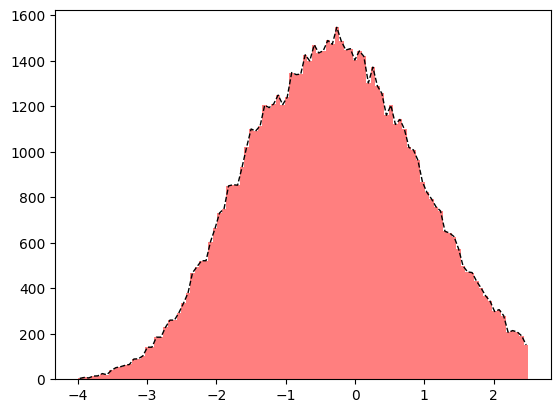

In [12]:
lw=1
#plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color='orange',label="Total Fit = bg+simN+simP")
#plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)

plt.bar(bin_centers1, bin_contents1, width=(bin_centers1[1] - bin_centers1[0]), align='center', alpha=0.5,color='red',label="Total Fit = bg+simN+simP")
plt.plot(bin_centers1, bin_contents1,'--',color='black',linewidth=lw)


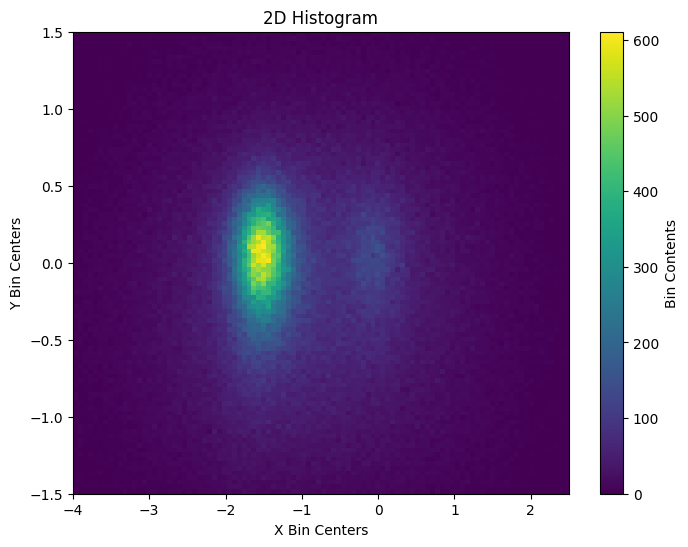

In [13]:
X, Y = np.meshgrid(bin_centers_x, bin_centers_y)

# Plotting the 2D histogram
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, data.T, shading='auto', cmap='viridis')
plt.colorbar(label='Bin Contents')

# Labeling the plot
plt.xlabel('X Bin Centers')
plt.ylabel('Y Bin Centers')
plt.title('2D Histogram')

# Show the plot
plt.show()

In [205]:
x_edges1, y_edges1, bin_contents1 = save[0] #data
x_edges2, y_edges2, bin_contents2 = save[2] #fit
x_edges3, y_edges3, bin_contents3 = save[4] #neutron
x_edges4, y_edges4, bin_contents4 = save[1] #background
x_edges5, y_edges5, bin_contents5 = save[3] #proton
x_edges6, y_edges6, bin_contents6 = save[5] #proton

In [206]:
import plotly.graph_objects as go
import numpy as np
fig = go.Figure()
if config=='2':
    countsmax=200
if config=='3':
    countsmax=200
if config=='4':
    countsmax=200

x_centers1 = (x_edges1[:-1] + x_edges1[1:]) / 2
y_centers1 = (y_edges1[:-1] + y_edges1[1:]) / 2

x_centers2 = (x_edges2[:-1] + x_edges2[1:]) / 2
y_centers2 = (y_edges2[:-1] + y_edges2[1:]) / 2

x_centers3 = (x_edges3[:-1] + x_edges3[1:]) / 2
y_centers3 = (y_edges3[:-1] + y_edges3[1:]) / 2

x_centers4 = (x_edges4[:-1] + x_edges4[1:]) / 2
y_centers4 = (y_edges4[:-1] + y_edges4[1:]) / 2

x_centers5 = (x_edges5[:-1] + x_edges5[1:]) / 2
y_centers5 = (y_edges5[:-1] + y_edges5[1:]) / 2

constant_color1 = np.ones_like(bin_contents1.T)
constant_color2 = np.ones_like(bin_contents2.T)

red_colorscale = [[0, 'rgba(255,0,0,0.6)'], [1, 'rgba(255,0,0,0.6)']]
blue_colorscale = [[0, 'rgba(0,0,255,0.6)'], [1, 'rgba(0,0,255,0.6)']]
dodger_blue_colorscale = [[0, 'rgba(30,144,255,0.6)'], [1, 'rgba(30,144,255,0.6)']]
orange_colorscale = [[0, 'rgba(255,165,0,0.6)'], [1, 'rgba(255,165,0,0.6)']]
magenta_colorscale = [[0, 'rgba(255,0,255,0.6)'], [1, 'rgba(255,0,255,0.6)']]
gray_colorscale = [[0, 'rgba(128,128,128,0.6)'], [1, 'rgba(128,128,128,0.6)']]
white_colorscale = [[0, 'rgba(255,255,255,0.6)'], [1, 'rgba(255,255,255,0.6)']]
green_colorscale = [[0, 'rgba(0,255,0,0.6)'], [1, 'rgba(0,255,0,0.6)']]

# Create the 3D histogram plot using plotly
alph=.8
#data
fig.add_trace(go.Surface(z=bin_contents1.T, x=x_centers1, y=y_centers1, colorscale=orange_colorscale, opacity=alph))

#neutron
fig.add_trace(go.Surface(z=bin_contents3.T, x=x_centers3, y=y_centers3,colorscale=dodger_blue_colorscale, opacity=alph))
#proton
fig.add_trace(go.Surface(z=bin_contents5.T, x=x_centers5, y=y_centers5,colorscale=red_colorscale, opacity=alph))
#background
fig.add_trace(go.Surface(z=bin_contents4.T, x=x_centers4, y=y_centers4,colorscale=magenta_colorscale, opacity=alph))
#fit
fig.add_trace(go.Surface(z=bin_contents2.T, x=x_centers2, y=y_centers2,colorscale=gray_colorscale, opacity=.2))


x_center = (dxmin + dxmax) / 2
y_center = (dymin + dymax) / 2
a = (dxmax - dxmin) / 2
b = (dymax - dymin) / 2
theta = np.linspace(0, 2 * np.pi, 20)
x_ellipse = x_center + a * np.cos(theta)
y_ellipse = y_center + b * np.sin(theta)
z_bottom = np.zeros_like(theta)
z_top = np.ones_like(theta) * countsmax
x_cylinder = np.concatenate([x_ellipse, x_ellipse])
y_cylinder = np.concatenate([y_ellipse, y_ellipse])
z_cylinder = np.concatenate([z_bottom, z_top])

# Create the vertex indices for the sides of the cylinder
i = []
j = []
k = []

num_points = len(theta)
for t in range(num_points - 1):
    i.extend([t, t, t + num_points])
    j.extend([t + 1, t + 1 + num_points, t + 1 + num_points])
    k.extend([t + num_points, t + 1, t])

# Close the cylinder by connecting the last points to the first
i.extend([num_points - 1, num_points - 1, 0])
j.extend([0, num_points, num_points])
k.extend([num_points, 0, num_points - 1])

# Add the cylindrical surface
fig.add_trace(go.Mesh3d(
    x=x_cylinder,
    y=y_cylinder,
    z=z_cylinder,
    i=i,
    j=j,
    k=k,
    color='black',
    opacity=0.05,
    name='Elliptical Cylinder'
))

fig.add_trace(go.Scatter3d(x=x_ellipse, y=y_ellipse, z=z_bottom, mode='lines', line=dict(color='black', width=2)))

# Add the top of the cylinder
fig.add_trace(go.Scatter3d(x=x_ellipse, y=y_ellipse, z=z_top, mode='lines', line=dict(color='black', width=2)))

# Add the sides of the cylinder
for i in range(len(theta)):
    fig.add_trace(go.Scatter3d(
        x=[x_ellipse[i], x_ellipse[i]],
        y=[y_ellipse[i], y_ellipse[i]],
        z=[z_bottom[i], z_top[i]],
        mode='lines',
        line=dict(color='black', width=1)
    ))
fig.update_layout(
    title='3D Histogram of hdx vs hdy',
    scene = dict(
        xaxis_title='dX',
        yaxis_title='dY',
        zaxis_title='Counts'
    ),
    width=1200,  # Adjust the width here
    height=800   # Adjust the height here
)
fig.update_layout(scene=dict(
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showbackground=True,
        backgroundcolor='white'
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showbackground=True,
        backgroundcolor='white'
    ),
    zaxis=dict(
        showgrid=False,
        zeroline=False,
        showbackground=True,
        backgroundcolor='white'
    ),
))
fig.show()

In [207]:
x_edges1, y_edges1, bin_contents1 = save[0] #data
x_edges2, y_edges2, bin_contents2 = save[2] #fit
x_edges3, y_edges3, bin_contents3 = save[4] #neutron
x_edges4, y_edges4, bin_contents4 = save[1] #background
x_edges5, y_edges5, bin_contents5 = save[3] #proton
x_edges6, y_edges6, bin_contents6 = save[5]

def counts_within_ellipse(x_edges, y_edges, bin_contents, dxmin, dxmax, dymin, dymax):
    # Calculate ellipse parameters
    
    x_center = (dxmin + dxmax) / 2
    y_center = (dymin + dymax) / 2
    a = (dxmax - dxmin) / 2
    b = (dymax - dymin) / 2
    
    total_counts = 0

    for i in range(len(x_edges) - 1):
        
        for j in range(len(y_edges) - 1):
            # Calculate bin center
            x_center_bin = (x_edges[i] + x_edges[i + 1]) / 2
            y_center_bin = (y_edges[j] + y_edges[j + 1]) / 2
            
            # Check if bin center is within ellipse
            if ((x_center_bin - x_center) / a) ** 2 + ((y_center_bin - y_center) / b) ** 2 <= 1:
                total_counts += bin_contents[i][j]
    #X, Y = np.meshgrid(x_edges, y_edges)
    #plt.pcolormesh(X, Y, bin_contents.T, shading='auto')
   # plt.colorbar(label='Counts')

   ## Drawing the ellipse
   # x_center = (dxmin + dxmax) / 2
   # y_center = (dymin + dymax) / 2
   # a = (dxmax - dxmin) / 2
   # b = (dymax - dymin) / 2

   # ellipse = Ellipse((x_center, y_center), width=2*a, height=2*b, edgecolor='r', facecolor='none', linewidth=2)
   # plt.gca().add_patch(ellipse)
   # plt.show()
    return total_counts

# Example usage:


Data = counts_within_ellipse(x_edges1, y_edges1, bin_contents1, dxmin, dxmax, dymin, dymax)
Fit = counts_within_ellipse(x_edges2, y_edges2, bin_contents2, dxmin, dxmax, dymin, dymax)
Neutrons = counts_within_ellipse(x_edges3, y_edges3, bin_contents3, dxmin, dxmax, dymin, dymax)
Background = counts_within_ellipse(x_edges4, y_edges4, bin_contents4, dxmin, dxmax, dymin, dymax)
Protons = counts_within_ellipse(x_edges5, y_edges5, bin_contents5, dxmin, dxmax, dymin, dymax)

print(f'Data: {Data} \nFit: {Fit}\nNeutrons: {Neutrons}\nBackground: {Background}\nProtons: {Protons}')


Data: 30621.0 
Fit: 31412.122032165527
Neutrons: 24684.669889450073
Background: 5914.619934082031
Protons: 812.8320729732513


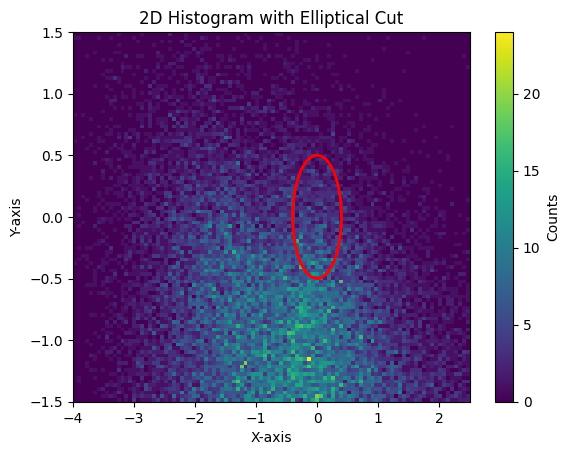

In [208]:
from matplotlib.patches import Ellipse
X, Y = np.meshgrid(x_edges6, y_edges6)
plt.pcolormesh(X, Y, bin_contents6.T, shading='auto')
plt.colorbar(label='Counts')

# Drawing the ellipse
x_center = (dxmin + dxmax) / 2
y_center = (dymin + dymax) / 2
a = (dxmax - dxmin) / 2
b = (dymax - dymin) / 2

ellipse = Ellipse((x_center, y_center), width=2*a, height=2*b, edgecolor='r', facecolor='none', linewidth=2)
plt.gca().add_patch(ellipse)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Histogram with Elliptical Cut')
plt.show()

In [209]:
Background/Data

0.19315567532353717

In [210]:
Neutrons/Data

0.8061353283514605

In [211]:
Protons/Data

0.026544922535947597

In [212]:
Neutrons/Background

4.173500607741285